<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [2327]:
#@title Current Date
Today = '2021-09-24' #@param {type:"date"}


In [2328]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "9022724" #@param {type:"string"}
Student_full_name = "Nigel Portley" #@param {type:"string"}
#@markdown ---

In [2329]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [2330]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2331]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2332]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [2333]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



In [2334]:
# Checking if using Google Colab (courtesy of Michael McKegney).
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # paste the path here, keep quotation marks and the trailing slash
    Path = '/content/drive/MyDrive/Colab Notebooks/Nigel 9022724/'
    
else:
    
    Path = '.'

In [2335]:
# Filenames of train, test & cost

filename1 = '/house_train.csv'

filename2 = '/house_test.csv'

filename3 = '/true_price.csv'

# training dataset: 
training_file = Path+filename1
# test dataset: 
testing_file = Path+filename2
# cost dataset: 
cost_file = Path+filename3

## Data Preparation
We will read in the training file and examine the data, with a view to preparing it for use in our algorithms:

In [2336]:
# load training dataset
df_train = pd.read_csv(training_file)

df_test = pd.read_csv(testing_file)

df_cost = pd.read_csv(cost_file)

df_train.tail()
#df_train.select_dtypes(include='object')

ad_id         area  bathrooms  beds ber_classification  county  \
2977  12428232  Ballsbridge        2.0   2.0                 C3  Dublin   
2978  12428240       Rialto        1.0   3.0                 B2  Dublin   
2979  12428247   Smithfield        1.0   2.0                 C3  Dublin   
2980  12428254      Foxrock        2.0   3.0                 C3  Dublin   
2981  12428358     Terenure        2.0   3.0                 D2  Dublin   

                                      description_block environment  \
2977  Sherry FitzGerald are delighted to present Apa...        prod   
2978  Property Team Patrick Moran is delighted to pr...        prod   
2979  Earnest estate agents are delighted to present...        prod   
2980  Janet Carroll Estate Agents are pleased to pre...        prod   
2981  ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...        prod   

                               facility  \
2977                                NaN   
2978                                NaN   
2979         Wired for Cable Television   
2980  Parking,Gas Fired Central Heating   
2981                                NaN   

                                               features   latitude  longitude  \
2977  Prime Location\nManagement Co: Core Property M...  53.338738  -6.237199   
2978  Totally refurbished to the highest standard. \...  53.335793  -6.294268   
2979  OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...  53.346098  -6.276856   
2980                                               None  53.273518  -6.178500   
2981  Charming three-bedroom family home\nMinutes aw...  53.310073  -6.325158   

      no_of_units     price property_category   property_type  surface  
2977          NaN  415000.0              sale       apartment     56.0  
2978          NaN  485000.0              sale        terraced    101.0  
2979          NaN  299000.0              sale       apartment     55.6  
2980          NaN  495000.0              sale  end-of-terrace     97.0  
2981          NaN  525000.0              sale   semi-detached    129.3

In [2405]:
df_cost.head()

Expected
0  875000.0
1  355000.0
2  440000.0
3  425000.0
4  265000.0

Let's first check what columns have the same value every time and drop them:

In [2338]:
columnlist = []
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()

for column in df_train:
    if (is_unique(df_train[column]) == True): 
        print (column)
        columnlist.append(str(column))
print (columnlist)
df_train.drop(columnlist, axis=1, inplace=True)

for column in df_test:
    if (is_unique(df_test[column]) == True): 
        print (column)
        columnlist.append(str(column))
print (columnlist)
df_test.drop(columnlist, axis=1, inplace=True)

county
environment
['county', 'environment']
county
environment
property_category
['county', 'environment', 'county', 'environment', 'property_category']


Columns 'description_block' and 'features' are free text and we will not be able to use them as features so they will be dropped from the dataset:

In [2339]:
df_train.drop('description_block', axis=1, inplace=True)
df_train.drop('features', axis=1, inplace=True)
df_test.drop('description_block', axis=1, inplace=True)
df_test.drop('features', axis=1, inplace=True)
df_train.tail()

ad_id         area  bathrooms  beds ber_classification  \
2977  12428232  Ballsbridge        2.0   2.0                 C3   
2978  12428240       Rialto        1.0   3.0                 B2   
2979  12428247   Smithfield        1.0   2.0                 C3   
2980  12428254      Foxrock        2.0   3.0                 C3   
2981  12428358     Terenure        2.0   3.0                 D2   

                               facility   latitude  longitude  no_of_units  \
2977                                NaN  53.338738  -6.237199          NaN   
2978                                NaN  53.335793  -6.294268          NaN   
2979         Wired for Cable Television  53.346098  -6.276856          NaN   
2980  Parking,Gas Fired Central Heating  53.273518  -6.178500          NaN   
2981                                NaN  53.310073  -6.325158          NaN   

         price property_category   property_type  surface  
2977  415000.0              sale       apartment     56.0  
2978  485000.0              sale        terraced    101.0  
2979  299000.0              sale       apartment     55.6  
2980  495000.0              sale  end-of-terrace     97.0  
2981  525000.0              sale   semi-detached    129.3

In [2340]:
pd.options.display.max_rows
pd.set_option('display.max_rows', 1000)
cat_cols = df_train.select_dtypes(include=object).columns.tolist()
(pd.DataFrame(
    df_train[cat_cols]
    .melt(var_name='column', value_name='value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['column', 'counts']))

counts
column             value                                                     
area               Coolmine                                                 1
                   Cherry Orchard                                           1
                   Bayside                                                  1
                   Ballinascorney                                           1
                   Ballymount                                               1
                   Carpenterstown                                           1
                   Deansgrange                                              1
                   Dolphin's Barn                                           1
                   Edenmore                                                 1
                   Hartstown                                                1
                   Kiltipper                                                1
                   Merrion                                                  1
                   Ard Na Greine                                            1
                   Oldbawn                                                  1
                   Islandbridge                                             1
                   Loughlinstown                                            2
                   The Coombe                                               2
                   Windy Arbour                                             2
                   Brittas                                                  2
                   Poppintree                                               2
                   South Circular Road                                      2
                   St Margaret's                                            2
                   Irishtown                                                3
                   Kilmore                                                  3
                   Greenhills                                               3
                   Clonshaugh                                               3
                   Dartry                                                   3
                   Kingswood                                                3
                   The Ward                                                 3
                   Ballybough                                               3
                   Temple Bar                                               3
                   Kilmacud                                                 4
                   Newcastle                                                4
                   Sallynoggin                                              4
                   Darndale                                                 4
                   Park West                                                4
                   Adamstown                                                5
                   Kilternan                                                5
                   Marino                                                   5
                   Clarehall                                                5
                   Garristown                                               5
                   Bluebell                                                 5
                   Mulhuddart                                               5
                   Leopardstown                                             5
                   Balrothery                                               6
                   Christchurch                                             6
                   Donnycarney                                              6
                   Loughshinny                                              6
                   Ballyboughal                                             6
                   Kilnamanagh                                              6
               

Facility is freetext and so not applicable as a feature; ad_id is a random identifier and so will also be deleted. Area is categorical and has too many possible values:

In [2341]:
df_train.drop('facility', axis=1, inplace=True)
df_train.drop('ad_id', axis=1, inplace=True)
df_train.drop('area', axis=1, inplace=True)

df_test.drop('facility', axis=1, inplace=True)
df_test.drop('area', axis=1, inplace=True)

Now to check which columns have blanks:

In [2342]:
df_train.isna().sum()

bathrooms               51
beds                    51
ber_classification     677
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

It seems beds, bathrooms & property_type have the same number of blanks together:

In [2343]:
df_train.loc[df_train['beds'].isna()].tail()

bathrooms  beds ber_classification   latitude  longitude  no_of_units  \
53        NaN   NaN                NaN  53.447579  -6.176803          8.0   
54        NaN   NaN                NaN  53.394563  -6.169685          3.0   
55        NaN   NaN                NaN  53.312983  -6.228114          4.0   
57        NaN   NaN                NaN  53.319865  -6.257336          2.0   
58        NaN   NaN                NaN  53.288383  -6.420396          2.0   

    price       property_category property_type  surface  
53    NaN  new_development_parent           NaN      NaN  
54    NaN  new_development_parent           NaN      NaN  
55    NaN  new_development_parent           NaN      NaN  
57    NaN  new_development_parent           NaN      NaN  
58    NaN  new_development_parent           NaN      NaN

In [2344]:
df_train.dropna(subset=['beds'], inplace=True)
df_test.dropna(subset=['beds'], inplace=True)

In [2345]:
df_train.isna().sum()

bathrooms                0
beds                     0
ber_classification     626
latitude                 0
longitude                0
no_of_units           2923
price                   39
property_category        0
property_type            0
surface                500
dtype: int64

If there is no price, there is no value in the line item as price is our output vector, so we drop the samples with no price:

In [2346]:
df_train.dropna(subset=['price'], inplace=True)

In [2347]:
df_train.isna().sum()

bathrooms                0
beds                     0
ber_classification     608
latitude                 0
longitude                0
no_of_units           2885
price                    0
property_category        0
property_type            0
surface                490
dtype: int64

#no_of_units is almost entirely unpopulated so will remove this column:

In [2348]:
df_train.drop('no_of_units', axis=1, inplace=True)
df_test.drop('no_of_units', axis=1, inplace=True)

<AxesSubplot:>

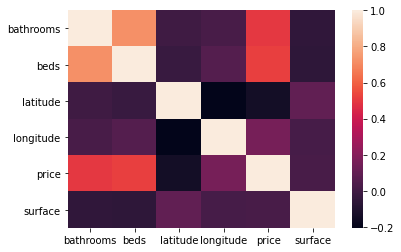

In [2349]:
sns.heatmap(df_train.corr())

While there are many blanks for 'ber_classification' and 'surface', it does not go over 25% of the number of samples. So we will populate the blanks for 'ber_classification' with 'C3' which is the median value and the blanks for 'surface' with the median value of the feature:

In [2350]:
df_train['ber_classification'].fillna('C3', inplace=True)
df_train['surface'].fillna(df_train['surface'].median(), inplace=True)

df_test['ber_classification'].fillna('C3', inplace=True)
df_test['surface'].fillna(df_test['surface'].median(), inplace=True)

In [2351]:
df_train.isna().sum()

bathrooms             0
beds                  0
ber_classification    0
latitude              0
longitude             0
price                 0
property_category     0
property_type         0
surface               0
dtype: int64

The challenge is to predict the final price of each house.

In [2352]:
df_train['ber_classification'].value_counts()

C3                     872
D1                     283
D2                     272
C2                     242
C1                     211
E1                     182
E2                     168
G                      164
F                      163
B3                     130
B2                      73
A3                      66
SINo666of2006exempt     25
A2                      24
B1                      16
A1                       1
Name: ber_classification, dtype: int64

In [2353]:
ber_classification_mapper = {
    "SINo666of2006exempt": 1,
    "A1": 2,
    "A2": 3,
    "A3": 4,
    "B1": 5,
    "B2": 6,
    "B3": 7,
    "C1": 8,
    "C2": 9,
    "C3": 10,
    "D1": 11,
    "D2": 12,
    "E1": 13,
    "E2": 14,
    "F": 15,
    "G": 16
}
df_train['ber_classification'] = df_train['ber_classification'].replace(ber_classification_mapper)
df_test['ber_classification'] = df_test['ber_classification'].replace(ber_classification_mapper)

In [2354]:
property_type_mapper = {
    "apartment": 1,
    "bungalow": 5,
    "detached": 9,
    "duplex": 2,
    "end-of-terrace": 6,
    "semi-detached": 8,
    "site": 3,
    "studio": 0,
    "terraced": 4,
    "townhouse": 7
}
df_train['property_type'] = df_train['property_type'].replace(property_type_mapper)
df_test['property_type'] = df_test['property_type'].replace(property_type_mapper)

In [2355]:
property_category_mapper = {
    "sale": 0,
    "new_development_parent": 1
}

df_train['property_category'] = df_train['property_category'].replace(property_category_mapper)
#df_test['property_category'] = df_test['property_category'].replace(property_category_mapper)
df_train.tail()

bathrooms  beds  ber_classification   latitude  longitude     price  \
2977        2.0   2.0                  10  53.338738  -6.237199  415000.0   
2978        1.0   3.0                   6  53.335793  -6.294268  485000.0   
2979        1.0   2.0                  10  53.346098  -6.276856  299000.0   
2980        2.0   3.0                  10  53.273518  -6.178500  495000.0   
2981        2.0   3.0                  12  53.310073  -6.325158  525000.0   

      property_category  property_type  surface  
2977                  0              1     56.0  
2978                  0              4    101.0  
2979                  0              1     55.6  
2980                  0              6     97.0  
2981                  0              8    129.3

<AxesSubplot:>

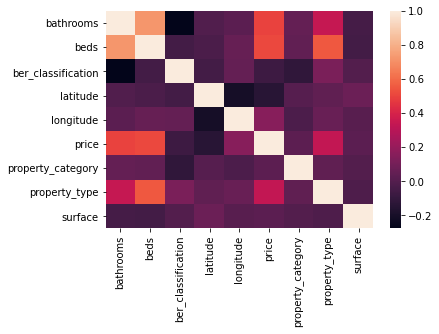

In [2356]:
sns.heatmap(df_train.corr())

Neither 'ber_classification' nor 'property_category' show meaningful correlations so we will remove them from the dataset:

In [2357]:
df_train.drop('ber_classification', axis=1, inplace=True)
df_train.drop('property_category', axis=1, inplace=True)

df_test.drop('ber_classification', axis=1, inplace=True)
#df_test.drop('property_category', axis=1, inplace=True)

In [2358]:
# Now to check for outliers
df_train.describe()

bathrooms         beds     latitude    longitude         price  \
count  2892.000000  2892.000000  2892.000000  2892.000000  2.892000e+03   
mean      1.991355     2.975450    53.355579    -6.257373  5.323536e+05   
std       1.266439     1.452494     0.086445     0.142864  5.678148e+05   
min       0.000000     0.000000    51.458439    -6.521183  1.999500e+04   
25%       1.000000     2.000000    53.299255    -6.313874  2.800000e+05   
50%       2.000000     3.000000    53.345455    -6.252335  3.800000e+05   
75%       3.000000     4.000000    53.388423    -6.197056  5.750000e+05   
max      18.000000    27.000000    53.630588    -1.744995  9.995000e+06   

       property_type        surface  
count    2892.000000    2892.000000  
mean        5.073306     278.567805  
std         3.037894    4023.929576  
min         0.000000       3.400000  
25%         1.000000      79.000000  
50%         5.000000      99.000000  
75%         8.000000     128.000000  
max         9.000000  182108.539008

There are some outlier values, i.e. 
bathrooms > 11: there is one very high value of 18 which needs to be normalised.
beds > 15: there is one value of 27 which needs to be normalised.
surface > 10000 or < 18: Surface areas less than 18 sqf or more than 10000 sqf are also to be normalised to the min & max values.
Also we need to normalise the values of each feature to within the range 0-1. In some cases we will use a logarithmic scale, and  in others just an add/subtract and a divisor:

In [2359]:
df_train['bathrooms'].values[df_train['bathrooms'].values > 11] = 11
df_train['beds'].values[df_train['beds'].values > 15] = 15
df_train['surface'].values[df_train['surface'].values < 18] = 18
df_train['surface'].values[df_train['surface'].values > 10000] = 10000
#df_train['surface'] = (np.log(df_train['surface']) - 2.89037)/6.32
#df_train['bathrooms'] = (df_train['bathrooms'])/11
#df_train['beds'] = (df_train['beds'])/15
df_train['latitude'] = (df_train['latitude'] -51.45843)/2.173
df_train['longitude'] = (df_train['longitude'] +6.521187)
#df_train['price'] = (np.log(df_train['price']) - 9.9)/6.22
#df_train['property_type'] = (df_train['property_type'])/9

df_test['bathrooms'].values[df_test['bathrooms'].values > 11] = 11
df_test['beds'].values[df_test['beds'].values > 15] = 15
df_test['surface'].values[df_test['surface'].values < 18] = 18
df_test['surface'].values[df_test['surface'].values > 10000] = 10000
#df_test['surface'] = (np.log(df_test['surface']) - 2.89037)/6.32
#df_test['bathrooms'] = (df_test['bathrooms'])/11
#df_test['beds'] = (df_test['beds'])/15
df_test['latitude'] = (df_test['latitude'] -51.45843)/2.173
df_test['longitude'] = (df_test['longitude'] +6.521187)
#df_test['property_type'] = (df_test['property_type'])/9

#df_cost['Expected'] = (np.log(df_cost['Expected']) - 9.9)/6.22

In [2360]:
df_train.describe()

bathrooms         beds     latitude    longitude         price  \
count  2892.000000  2892.000000  2892.000000  2892.000000  2.892000e+03   
mean      1.983748     2.967151     0.873055     0.263814  5.323536e+05   
std       1.192365     1.345513     0.039781     0.142864  5.678148e+05   
min       0.000000     0.000000     0.000004     0.000004  1.999500e+04   
25%       1.000000     2.000000     0.847136     0.207313  2.800000e+05   
50%       2.000000     3.000000     0.868396     0.268852  3.800000e+05   
75%       3.000000     4.000000     0.888170     0.324131  5.750000e+05   
max      11.000000    15.000000     0.999613     4.776192  9.995000e+06   

       property_type       surface  
count    2892.000000   2892.000000  
mean        5.073306    160.828254  
std         3.037894    555.381103  
min         0.000000     18.000000  
25%         1.000000     79.000000  
50%         5.000000     99.000000  
75%         8.000000    128.000000  
max         9.000000  10000.000000

<AxesSubplot:>

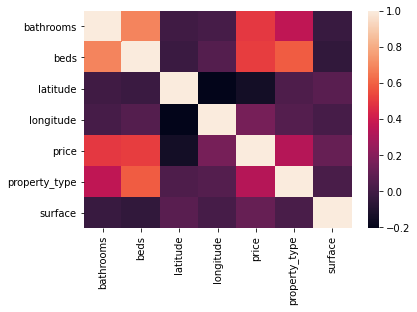

In [2361]:
sns.heatmap(df_train.corr())

In [2362]:
df_train.head()

bathrooms  beds  latitude  longitude      price  property_type  surface
15        3.0   5.0  0.893706   0.075457   935000.0              9    321.0
26        4.0   4.0  0.855030   0.135973   485000.0              8    144.0
27        3.0   5.0  0.894148   0.074553   935000.0              9    321.0
35        5.0   5.0  0.882166   0.464438  1475000.0              9    312.0
38        2.0   2.0  0.880672   0.182721   410000.0              1     83.0

## Training & Test Data

In [2363]:
# split data into training and test
from sklearn.model_selection import train_test_split

y = df_train['price']
X = df_train.drop('price', axis=1).values
# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

### Train dataset

In [2364]:
# training dataset: 
#training_file = syntPath+filename1
# test dataset: 
#testing_file = syntPath+filename2
# cost dataset: 
#cost_file = syntPath+filename3

In [2365]:
# show first data frame rows 
df_train.head()

bathrooms  beds  latitude  longitude      price  property_type  surface
15        3.0   5.0  0.893706   0.075457   935000.0              9    321.0
26        4.0   4.0  0.855030   0.135973   485000.0              8    144.0
27        3.0   5.0  0.894148   0.074553   935000.0              9    321.0
35        5.0   5.0  0.882166   0.464438  1475000.0              9    312.0
38        2.0   2.0  0.880672   0.182721   410000.0              1     83.0

In [2366]:
#print (df_train[697],X_ind[791])
df_train = df_train[['bathrooms', 'beds', 'latitude', 'longitude', 'property_type', 'surface', 'price']]

In [2367]:
# Generate descriptive statistics
df_train.describe()

bathrooms         beds     latitude    longitude  property_type  \
count  2892.000000  2892.000000  2892.000000  2892.000000    2892.000000   
mean      1.983748     2.967151     0.873055     0.263814       5.073306   
std       1.192365     1.345513     0.039781     0.142864       3.037894   
min       0.000000     0.000000     0.000004     0.000004       0.000000   
25%       1.000000     2.000000     0.847136     0.207313       1.000000   
50%       2.000000     3.000000     0.868396     0.268852       5.000000   
75%       3.000000     4.000000     0.888170     0.324131       8.000000   
max      11.000000    15.000000     0.999613     4.776192       9.000000   

            surface         price  
count   2892.000000  2.892000e+03  
mean     160.828254  5.323536e+05  
std      555.381103  5.678148e+05  
min       18.000000  1.999500e+04  
25%       79.000000  2.800000e+05  
50%       99.000000  3.800000e+05  
75%      128.000000  5.750000e+05  
max    10000.000000  9.995000e+06

In [2368]:
# Correlate expected price in df_cost with df_test row via property_id:
df_subset_test  =  df_test.dropna(axis=0)
# cost
df_cost = df_cost[df_cost.Id.isin(df_subset_test.ad_id)]

Now we have correlated the Id in df_cost to the ad_id in df_test we can delete those identifiers:

In [2369]:
df_test.drop('ad_id', axis=1, inplace=True)
df_cost.drop('Id', axis=1, inplace=True)

### Test dataset

In [2370]:
# show first data frame rows 
df_test.head()

bathrooms  beds  latitude  longitude  property_type  surface
0        2.0   4.0  0.970295   0.420039              5    142.0
1        2.0   3.0  0.876467   0.068278              4    114.0
2        3.0   4.0  0.918439   0.258223              8    172.0
3        4.0   3.0  0.872514   0.062540              8    132.4
4        1.0   3.0  0.864289   0.127600              8     88.0

In [2371]:
# Generate descriptive statistics
df_test.describe()

bathrooms        beds    latitude   longitude  property_type  \
count  500.000000  500.000000  500.000000  500.000000     500.000000   
mean     1.994000    2.930000    0.873265    0.273345       5.084000   
std      1.106532    1.191612    0.037692    0.088552       3.085447   
min      0.000000    0.000000    0.811283    0.024200       0.000000   
25%      1.000000    2.000000    0.846269    0.224783       1.000000   
50%      2.000000    3.000000    0.865677    0.277615       5.000000   
75%      3.000000    4.000000    0.885053    0.336132       8.000000   
max      8.000000    7.000000    0.994636    0.456313       9.000000   

           surface  
count   500.000000  
mean    156.007671  
std     344.497362  
min      33.500000  
25%      72.375000  
50%      98.000000  
75%     138.935000  
max    5746.536120

### Expected Cost dataset

In [2372]:
# Generate descriptive statistics
df_cost.describe()

Expected
count  5.000000e+02
mean   5.810356e+05
std    6.009194e+05
min    8.500000e+04
25%    2.950000e+05
50%    4.250000e+05
75%    5.950000e+05
max    5.750000e+06

# PIECEWISE REGRESSION

## Full Model

In [2373]:
print('Number of nan in df_subset_train dataset: ',df_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [2374]:
# train set, input columns
Xs_train = df_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost.Expected.values

In [2375]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [2376]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 2,968.5


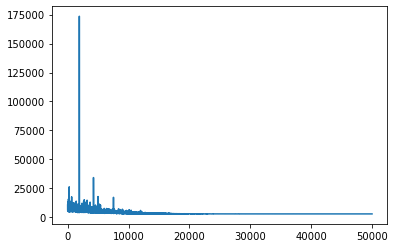

In [2377]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [2378]:
# samples from the posterior
posterior = approximation.sample(5000)

In [2379]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  204697.86765224583
MAPE =  0.2648494672416066


## Clustering

### Full Model

3392

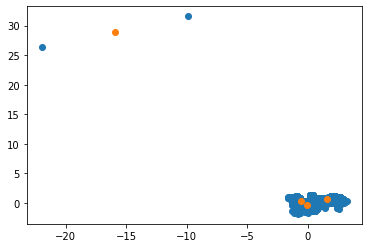

In [2380]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])
len(X_ind)

There are two outliers that are skewing the graph; we shall remove them:

In [2381]:
from sys import maxsize
from numpy import set_printoptions
#row 792, 698
set_printoptions(threshold=maxsize)
len (X_ind)
print (X_ind[697],X_ind[791])
np.amax(X_ind)
#np.amin(X_ind)

indexes = np.array([697,791])
X_ind = np.delete(X_ind, indexes, axis=0)
Xn_train = np.delete(Xn_train, indexes, axis=0)
ys_train = np.delete(ys_train, indexes, axis=0)

[-9.8776487  31.59059213] [-21.95008442  26.33136806]


Now to redo the clustering:

3390

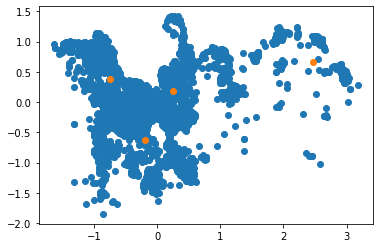

In [2382]:
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])
len(X_ind)

In [2383]:
len(ys_train)

2890

In [2384]:
np.max(ys_train)

9995000.0

### Clusters

In [2385]:
# train clusters
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 708, 1: 913, 2: 187, 3: 1082}

In [2386]:
len(Xn_test)

500

In [2387]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 143, 1: 140, 2: 42, 3: 175}

In [2388]:
len(clusters_train)

2890

In [2389]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [2390]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [2391]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [2392]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [2393]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 668.89


In [2394]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 974.67


In [2395]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 241.37


In [2396]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,072.3


In [2397]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

##Simulations

### Only Cluster 0

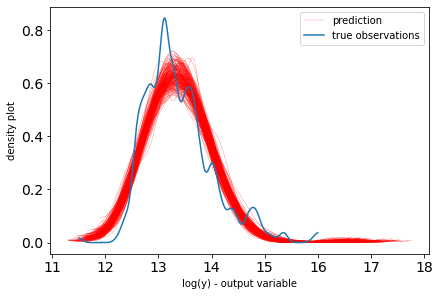

In [2398]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

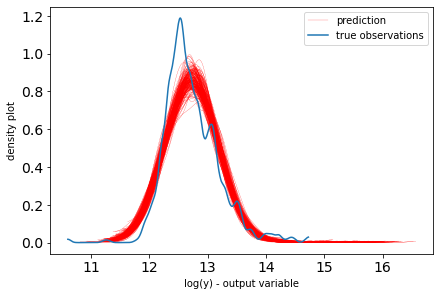

In [2399]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

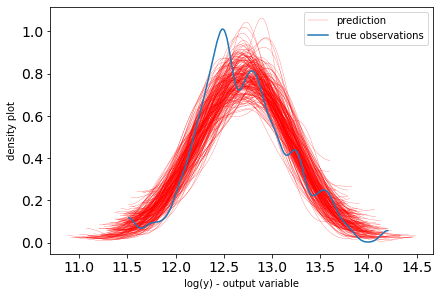

In [2400]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

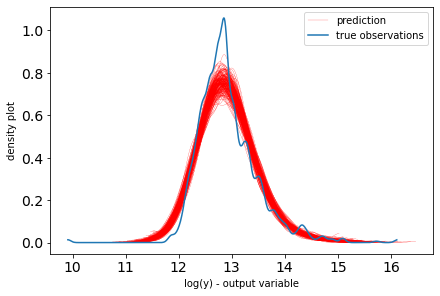

In [2401]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

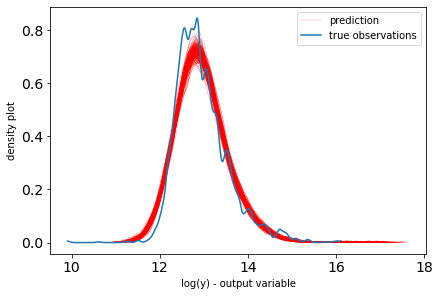

In [2402]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [2403]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 143 , MAE Cluster0= 308120.04348110076
Size Cluster1 140 , MAE Cluster1= 113767.40752592961
Size Cluster2 42 , MAE Cluster2= 93803.1394648479
Size Cluster3 175 , MAE Cluster3= 135543.53628711557
MAE= 175296.90795839278


### PPC on the Test set



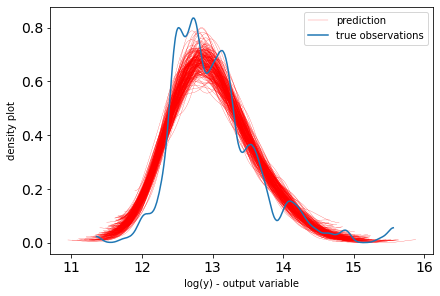

In [2404]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY